In [1]:
# Notebook: 01_download_era5.ipynb
# Purpose: ERA5 から 2m気温・2m露点温度をダウンロードし、
#          露点温度から相対湿度を計算 → WBGT を推定 → 国別集計

# --------------------------------------------------
# 0. 事前準備
#   - ~/.cdsapirc に CDS API キーが設定済み
#   - 必要なライブラリがインストール済み (requirements.txt 参照)
# --------------------------------------------------

# 1. ライブラリ読み込み
import cdsapi
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import os
import time

In [2]:
# --------------------------------------------------
# 2. 設定：取得年リスト・領域・グリッド
# --------------------------------------------------

years = [str(y) for y in range(2000, 2024)]  # 2000〜2023年
area = [35, 60, 5, 100]   # [北, 西, 南, 東]：南アジアバウンディングボックス
grid = [0.25, 0.25]       # 0.25°×0.25°解像度

# 出力ディレクトリを作成
os.makedirs("../data/raw/era5/temperature", exist_ok=True)
os.makedirs("../data/raw/era5/dewpoint", exist_ok=True)
os.makedirs("../data/processed/wbgt", exist_ok=True)
os.makedirs("../figures/wbgt", exist_ok=True)

In [3]:
# CDS API クライアント
c = cdsapi.Client()

# --------------------------------------------------
# 3. リトライ付きダウンロード関数を定義
# --------------------------------------------------

def download_era5_monthly(variable, year, out_path, max_retries=5, wait_seconds=120):
    """
    ERA5 月平均データをダウンロード（リトライ付き）。
    - variable: "2m_temperature" または "2m_dewpoint_temperature"
    - year: 年 (文字列)
    - out_path: 保存先ファイルパス (例: "../data/raw/era5/temperature/era5_t2m_2000.nc")
    """
    params = {
        
        "product_type": ["monthly_averaged_reanalysis"],
        "data_format": "netcdf",
        "download_format": ["unarchived"],
        "variable": [variable],
        "year": year,
        "month": [
            "01", "02", "03", "04", "05", "06",
            "07", "08", "09", "10", "11", "12"
        ],
        "time": ["00:00"],
        "area": area,
        "grid": grid,
    }

    attempt = 0
    while attempt < max_retries:
        try:
            print(f"Downloading {variable} for {year} (attempt {attempt+1}/{max_retries})...")
            c.retrieve("reanalysis-era5-single-levels-monthly-means", params, out_path)
            print(f"  → Success: {out_path}")
            return True
        except Exception as e:
            attempt += 1
            print(f"  → Error on attempt {attempt}: {e}")
            if attempt < max_retries:
                print(f"  Waiting {wait_seconds} seconds before retrying...")
                time.sleep(wait_seconds)
            else:
                print(f"  → Failed to download {variable} for {year} after {max_retries} attempts. Skipping.")
                return False

2025-06-04 22:09:16,412 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.


In [4]:
# --------------------------------------------------
# 4. 露点温度から相対湿度を計算する関数
# --------------------------------------------------

def calculate_relative_humidity(t_celsius, td_celsius):
    """
    露点温度 (Td) と気温 (T) から相対湿度 (RH) (%) を計算。
    Magnus の公式を活用：
      RH = 100 * (exp(17.625 * Td / (243.04 + Td)) / exp(17.625 * T / (243.04 + T)))
    - t_celsius: 気温 [℃] (xarray DataArray)
    - td_celsius: 露点温度 [℃] (xarray DataArray)
    """
    # 式中の定数
    a = 17.625
    b = 243.04

    # 飽和蒸気圧の指数部
    alpha_td = (a * td_celsius) / (b + td_celsius)
    alpha_t  = (a * t_celsius)  / (b + t_celsius)

    # RH (0～100%)
    rh = 100.0 * (np.exp(alpha_td) / np.exp(alpha_t))
    # 値を 0～100 にクリップ
    rh = rh.clip(min=0, max=100)
    return rh

In [5]:
# --------------------------------------------------
# 5. メインループ：年ごとにデータ取得→WBGT計算→国別集計
# --------------------------------------------------

for year in years:
    print(f"\n=== Processing year {year} ===")

    # 5.1 2m気温のダウンロード
    t_filename = f"../data/raw/era5/temperature/era5_t2m_{year}.nc"
    if not os.path.exists(t_filename):
        ok_t = download_era5_monthly("2m_temperature", year, t_filename)
    else:
        print(f"  {t_filename} already exists. Skipping.")
        ok_t = True

    # 5.2 2m露点温度のダウンロード
    td_filename = f"../data/raw/era5/dewpoint/era5_td2m_{year}.nc"
    if not os.path.exists(td_filename):
        ok_td = download_era5_monthly("2m_dewpoint_temperature", year, td_filename)
    else:
        print(f"  {td_filename} already exists. Skipping.")
        ok_td = True

    # ダウンロード失敗時はスキップ
    if not (ok_t and ok_td):
        print(f"  → Skipping WBGT calculation for {year} due to download failure.")
        continue

    # --------------------------------------------------
    # 6. データ読み込みと単位変換
    # --------------------------------------------------

    # 6.1 2m気温 (K → ℃)
    ds_t2m = xr.open_dataset(t_filename)
    t2m = ds_t2m["t2m"] - 273.15  # DataArray (time, lat, lon)

    # 6.2 2m露点温度 (K → ℃)
    ds_td2m = xr.open_dataset(td_filename)
    td2m = ds_td2m["d2m"] - 273.15  # DataArray (time, lat, lon)

    # --------------------------------------------------
    # 7. 相対湿度 (RH) の計算 (月次)
    # --------------------------------------------------

    # calculate_relative_humidity() は xarray DataArray に対応
    rh_monthly = calculate_relative_humidity(t2m, td2m)  # (time, lat, lon)

    # --------------------------------------------------
    # 8. WBGT の近似計算
    # --------------------------------------------------

    def calculate_wbgt(t_celsius, rh_percent):
        """
        WBGT の簡易推定式（米軍式近似）：
          Tw を近似計算し、WBGT ≈ 0.7 × Tw + 0.3 × T
        - t_celsius: 気温 [℃] (DataArray)
        - rh_percent: 相対湿度 [%] (DataArray)
        """
        tw = (
            t_celsius * np.arctan(0.151977 * np.sqrt(rh_percent + 8.313659))
            + np.arctan(t_celsius + rh_percent)
            - np.arctan(rh_percent - 1.676331)
            + 0.00391838 * (rh_percent ** 1.5) * np.arctan(0.023101 * rh_percent)
            - 4.686035
        )
        wbgt = 0.7 * tw + 0.3 * t_celsius
        return wbgt

    wbgt_monthly = calculate_wbgt(t2m, rh_monthly)  # (time, lat, lon)
    wbgt_annual = wbgt_monthly.mean(dim="valid_time")     # (lat, lon)

    # --------------------------------------------------
    # 9. 国別集計の準備（初回のみ）
    # --------------------------------------------------

    if year == years[0]:
        # オンライン公開されている GeoJSON を直接読み込む
        world_geojson_url = "https://raw.githubusercontent.com/johan/world.geo.json/master/countries.geo.json"
        gdf_countries = gpd.read_file(world_geojson_url)
    
        # 対象国リスト
        south_asia_countries = ["India", "Bangladesh", "Pakistan", "Nepal", "Sri Lanka", "Bhutan"]
        # country 列が "name" になっているので、そのままフィルタ
        gdf_sa = gdf_countries[gdf_countries["name"].isin(south_asia_countries)].copy()
    
        # ERA5 グリッドの緯度・経度を一度だけ作成
        lats = wbgt_annual.latitude.values
        lons = wbgt_annual.longitude.values
        lat_mesh, lon_mesh = np.meshgrid(lats, lons, indexing="ij")
        coords = np.vstack([lon_mesh.ravel(), lat_mesh.ravel()]).T  # (N, 2)
    
        gdf_points_base = gpd.GeoDataFrame(
            geometry=gpd.points_from_xy(coords[:, 0], coords[:, 1]),
            crs="EPSG:4326"
        )

    # --------------------------------------------------
    # 10. 国別平均 WBGT の算出
    # --------------------------------------------------

    # 座標データフレームをコピーして WBGT 値を付与
    gdf_points = gdf_points_base.copy()
    gdf_points["wbgt"] = wbgt_annual.values.ravel()

    # 空間結合 (points within country polygons)
    gdf_joined = gpd.sjoin(gdf_points, gdf_sa, how="inner", predicate="within")

    # 国別 WBGT の平均値を計算
    df_wbgt_country = (
        gdf_joined.groupby("name")["wbgt"]
        .mean()
        .reset_index()
        .rename(columns={"name": "country", "wbgt": "mean_wbgt"})
    )

    # --------------------------------------------------
    # 11. 結果の保存と可視化
    # --------------------------------------------------

    # CSV保存
    out_csv = f"../data/processed/wbgt/wbgt_by_country_{year}.csv"
    df_wbgt_country.to_csv(out_csv, index=False)

    # 簡易棒グラフを保存
    plt.figure(figsize=(6, 3))
    df_plot = df_wbgt_country.sort_values("mean_wbgt", ascending=False)
    plt.bar(df_plot["country"], df_plot["mean_wbgt"], color="tomato")
    plt.title(f"Average Annual WBGT (°C) - {year}")
    plt.ylabel("WBGT (°C)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f"../figures/wbgt/wbgt_by_country_{year}.png", dpi=200)
    plt.close()

    print(f"  → Year {year} WBGT by country saved.")


=== Processing year 2000 ===
  ../data/raw/era5/temperature/era5_t2m_2000.nc already exists. Skipping.
  ../data/raw/era5/dewpoint/era5_td2m_2000.nc already exists. Skipping.
  → Year 2000 WBGT by country saved.

=== Processing year 2001 ===


2025-06-04 22:09:34,327 INFO Request ID is 464fd2e3-fa02-4cac-9841-5d532bcf05a2
2025-06-04 22:09:34,736 INFO status has been updated to accepted
Recovering from HTTP error [500 Internal Server Error], attempt 1 of 500
Retrying in 120 seconds
2025-06-04 22:11:39,309 WARNING Structural differences in grib fields detected when opening in xarray. Opening the grib file safely, however this may result in files with non-intuitive filenames.
2025-06-04 22:11:39,309 INFO status has been updated to successful
                                                                                      

  → Success: ../data/raw/era5/temperature/era5_t2m_2001.nc


2025-06-04 22:11:45,097 INFO Request ID is 3b6dc966-33d5-4c4c-b135-69a5e267b0c4
2025-06-04 22:11:45,531 INFO status has been updated to accepted
Recovering from HTTP error [500 Internal Server Error], attempt 1 of 500
Retrying in 120 seconds
2025-06-04 22:13:52,511 WARNING Structural differences in grib fields detected when opening in xarray. Opening the grib file safely, however this may result in files with non-intuitive filenames.
2025-06-04 22:13:52,514 INFO status has been updated to successful
                                                                                       

  → Success: ../data/raw/era5/dewpoint/era5_td2m_2001.nc
  → Year 2001 WBGT by country saved.

=== Processing year 2002 ===


2025-06-04 22:14:01,100 INFO Request ID is b66bed8f-b05b-43e8-9eea-825c9dfb7eb5
2025-06-04 22:14:01,423 INFO status has been updated to accepted
Recovering from HTTP error [500 Internal Server Error], attempt 1 of 500
Retrying in 120 seconds
2025-06-04 22:16:05,868 WARNING Structural differences in grib fields detected when opening in xarray. Opening the grib file safely, however this may result in files with non-intuitive filenames.
2025-06-04 22:16:05,869 INFO status has been updated to successful
                                                                                      

  → Success: ../data/raw/era5/temperature/era5_t2m_2002.nc


2025-06-04 22:16:11,916 INFO Request ID is c281bf0c-614c-43a7-bca1-4d21396c91c9
2025-06-04 22:16:12,288 INFO status has been updated to accepted
2025-06-04 22:16:35,491 WARNING Structural differences in grib fields detected when opening in xarray. Opening the grib file safely, however this may result in files with non-intuitive filenames.
2025-06-04 22:16:35,491 INFO status has been updated to successful
                                                                                       

  → Success: ../data/raw/era5/dewpoint/era5_td2m_2002.nc
  → Year 2002 WBGT by country saved.

=== Processing year 2003 ===


2025-06-04 22:16:42,760 INFO Request ID is 209d15ec-2d8d-483d-aedb-7dddd28fc870
2025-06-04 22:16:43,100 INFO status has been updated to accepted
Recovering from HTTP error [500 Internal Server Error], attempt 1 of 500
Retrying in 120 seconds
2025-06-04 22:18:45,490 WARNING Structural differences in grib fields detected when opening in xarray. Opening the grib file safely, however this may result in files with non-intuitive filenames.
2025-06-04 22:18:45,492 INFO status has been updated to successful
                                                                                      

  → Success: ../data/raw/era5/temperature/era5_t2m_2003.nc


2025-06-04 22:18:51,790 INFO Request ID is 54ac278d-8f84-4639-b8b8-855ce0780e14
2025-06-04 22:18:52,144 INFO status has been updated to accepted
Recovering from HTTP error [500 Internal Server Error], attempt 1 of 500
Retrying in 120 seconds
2025-06-04 22:20:54,622 WARNING Structural differences in grib fields detected when opening in xarray. Opening the grib file safely, however this may result in files with non-intuitive filenames.
2025-06-04 22:20:54,624 INFO status has been updated to successful
                                                                                      

  → Success: ../data/raw/era5/dewpoint/era5_td2m_2003.nc
  → Year 2003 WBGT by country saved.

=== Processing year 2004 ===


2025-06-04 22:21:00,002 INFO Request ID is e0084fd5-7601-49ea-b839-71c7e3f737fa
2025-06-04 22:21:00,368 INFO status has been updated to accepted
Recovering from HTTP error [500 Internal Server Error], attempt 1 of 500
Retrying in 120 seconds
2025-06-04 22:23:11,199 WARNING Structural differences in grib fields detected when opening in xarray. Opening the grib file safely, however this may result in files with non-intuitive filenames.
2025-06-04 22:23:11,200 INFO status has been updated to successful
                                                                                      

  → Success: ../data/raw/era5/temperature/era5_t2m_2004.nc


2025-06-04 22:23:16,142 INFO Request ID is dba66f6b-f4b4-47ac-bb03-9c4bd55f824f
2025-06-04 22:23:16,468 INFO status has been updated to accepted
2025-06-04 22:23:22,399 INFO status has been updated to running
2025-06-04 22:23:26,236 WARNING Structural differences in grib fields detected when opening in xarray. Opening the grib file safely, however this may result in files with non-intuitive filenames.
Recovering from HTTP error [500 Internal Server Error], attempt 1 of 500
Retrying in 120 seconds
2025-06-04 22:25:32,713 INFO status has been updated to successful
                                                                                      

  → Success: ../data/raw/era5/dewpoint/era5_td2m_2004.nc
  → Year 2004 WBGT by country saved.

=== Processing year 2005 ===


2025-06-04 22:25:38,266 INFO Request ID is 52efcc43-34fd-40c7-b7e6-f029096a90b8
Recovering from HTTP error [500 Internal Server Error], attempt 1 of 500
Retrying in 120 seconds
2025-06-04 22:27:39,503 WARNING Structural differences in grib fields detected when opening in xarray. Opening the grib file safely, however this may result in files with non-intuitive filenames.
2025-06-04 22:27:39,506 INFO status has been updated to successful
                                                                                      

  → Success: ../data/raw/era5/temperature/era5_t2m_2005.nc


2025-06-04 22:27:44,732 INFO Request ID is 3cb9fc9f-8586-40fc-a726-83fb0a1f4608
2025-06-04 22:27:45,085 INFO status has been updated to accepted
Recovering from HTTP error [500 Internal Server Error], attempt 1 of 500
Retrying in 120 seconds
2025-06-04 22:29:51,973 WARNING Structural differences in grib fields detected when opening in xarray. Opening the grib file safely, however this may result in files with non-intuitive filenames.
2025-06-04 22:29:51,973 INFO status has been updated to successful
                                                                                      

  → Success: ../data/raw/era5/dewpoint/era5_td2m_2005.nc
  → Year 2005 WBGT by country saved.

=== Processing year 2006 ===


2025-06-04 22:29:58,787 INFO Request ID is e96df39f-9d8a-465b-82f9-3d7c48f0952e
2025-06-04 22:29:59,138 INFO status has been updated to accepted
2025-06-04 22:30:14,439 WARNING Structural differences in grib fields detected when opening in xarray. Opening the grib file safely, however this may result in files with non-intuitive filenames.
2025-06-04 22:30:14,439 INFO status has been updated to running
2025-06-04 22:30:22,378 INFO status has been updated to successful
                                                                                      

  → Success: ../data/raw/era5/temperature/era5_t2m_2006.nc


2025-06-04 22:30:30,464 INFO Request ID is 1761c379-8c53-4987-8a93-90af6befbebe
2025-06-04 22:30:31,054 INFO status has been updated to accepted
2025-06-04 22:30:54,569 WARNING Structural differences in grib fields detected when opening in xarray. Opening the grib file safely, however this may result in files with non-intuitive filenames.
2025-06-04 22:30:54,569 INFO status has been updated to running
2025-06-04 22:31:06,309 INFO status has been updated to successful
                                                                                      

  → Success: ../data/raw/era5/dewpoint/era5_td2m_2006.nc
  → Year 2006 WBGT by country saved.

=== Processing year 2007 ===


2025-06-04 22:31:13,398 INFO Request ID is 4e0fee25-393d-47a5-b55e-8945a98128a2
2025-06-04 22:31:13,790 INFO status has been updated to accepted
2025-06-04 22:31:23,323 WARNING Structural differences in grib fields detected when opening in xarray. Opening the grib file safely, however this may result in files with non-intuitive filenames.
2025-06-04 22:31:23,330 INFO status has been updated to successful
                                                                                      

  → Success: ../data/raw/era5/temperature/era5_t2m_2007.nc


2025-06-04 22:31:29,169 INFO Request ID is d15f4578-9061-4c65-86da-1c791b894de9
2025-06-04 22:31:29,510 INFO status has been updated to accepted
2025-06-04 22:31:44,524 WARNING Structural differences in grib fields detected when opening in xarray. Opening the grib file safely, however this may result in files with non-intuitive filenames.
2025-06-04 22:31:44,528 INFO status has been updated to running
2025-06-04 22:31:52,472 INFO status has been updated to successful
                                                                                      

  → Success: ../data/raw/era5/dewpoint/era5_td2m_2007.nc
  → Year 2007 WBGT by country saved.

=== Processing year 2008 ===


2025-06-04 22:31:58,807 INFO Request ID is bcffc72f-0531-40b5-bf79-4aae8c810dbe
2025-06-04 22:31:59,148 INFO status has been updated to accepted
2025-06-04 22:32:04,972 INFO status has been updated to running
2025-06-04 22:32:08,965 WARNING Structural differences in grib fields detected when opening in xarray. Opening the grib file safely, however this may result in files with non-intuitive filenames.
2025-06-04 22:32:14,374 INFO status has been updated to successful
                                                                                      

  → Success: ../data/raw/era5/temperature/era5_t2m_2008.nc


Recovering from HTTP error [500 Internal Server Error], attempt 1 of 500
Retrying in 120 seconds
2025-06-04 22:34:20,751 INFO Request ID is 9b3c85fc-9919-48a5-bbcb-b1c7355d6518
2025-06-04 22:34:21,116 INFO status has been updated to accepted
Recovering from HTTP error [500 Internal Server Error], attempt 1 of 500
Retrying in 120 seconds
2025-06-04 22:36:23,450 WARNING Structural differences in grib fields detected when opening in xarray. Opening the grib file safely, however this may result in files with non-intuitive filenames.
2025-06-04 22:36:23,450 INFO status has been updated to successful
                                                                                      

  → Success: ../data/raw/era5/dewpoint/era5_td2m_2008.nc
  → Year 2008 WBGT by country saved.

=== Processing year 2009 ===


2025-06-04 22:36:29,531 INFO Request ID is 6411e3a2-51eb-4b8a-bcd1-428524ae4651
2025-06-04 22:36:29,889 INFO status has been updated to accepted
Recovering from HTTP error [500 Internal Server Error], attempt 1 of 500
Retrying in 120 seconds
2025-06-04 22:38:36,832 WARNING Structural differences in grib fields detected when opening in xarray. Opening the grib file safely, however this may result in files with non-intuitive filenames.
2025-06-04 22:38:36,832 INFO status has been updated to successful
                                                                                      

  → Success: ../data/raw/era5/temperature/era5_t2m_2009.nc


2025-06-04 22:38:43,762 INFO Request ID is c893fb98-5db9-47b0-ad04-4c4e27308917
2025-06-04 22:38:44,130 INFO status has been updated to accepted
2025-06-04 22:39:00,125 WARNING Structural differences in grib fields detected when opening in xarray. Opening the grib file safely, however this may result in files with non-intuitive filenames.
2025-06-04 22:39:00,127 INFO status has been updated to running
2025-06-04 22:39:08,068 INFO status has been updated to successful
                                                                                      

  → Success: ../data/raw/era5/dewpoint/era5_td2m_2009.nc
  → Year 2009 WBGT by country saved.

=== Processing year 2010 ===


2025-06-04 22:39:15,452 INFO Request ID is 8c364814-3867-4f55-8d63-9753dfac859c
2025-06-04 22:39:15,809 INFO status has been updated to accepted
Recovering from HTTP error [500 Internal Server Error], attempt 1 of 500
Retrying in 120 seconds
2025-06-04 22:41:26,311 WARNING Structural differences in grib fields detected when opening in xarray. Opening the grib file safely, however this may result in files with non-intuitive filenames.
2025-06-04 22:41:26,319 INFO status has been updated to successful
                                                                                       

  → Success: ../data/raw/era5/temperature/era5_t2m_2010.nc


2025-06-04 22:41:34,144 INFO Request ID is 139f2ed8-be28-42ab-9602-f1b1d9ab5ec4
Recovering from HTTP error [500 Internal Server Error], attempt 1 of 500
Retrying in 120 seconds
2025-06-04 22:43:35,648 WARNING Structural differences in grib fields detected when opening in xarray. Opening the grib file safely, however this may result in files with non-intuitive filenames.
2025-06-04 22:43:35,664 INFO status has been updated to successful
                                                                                       

  → Success: ../data/raw/era5/dewpoint/era5_td2m_2010.nc
  → Year 2010 WBGT by country saved.

=== Processing year 2011 ===


2025-06-04 22:43:42,737 INFO Request ID is 5bf9e609-56ed-4514-a776-ce87c41ae18a
2025-06-04 22:43:43,184 INFO status has been updated to accepted
2025-06-04 22:44:06,284 WARNING Structural differences in grib fields detected when opening in xarray. Opening the grib file safely, however this may result in files with non-intuitive filenames.
2025-06-04 22:44:06,284 INFO status has been updated to running
2025-06-04 22:44:35,505 INFO status has been updated to successful
                                                                                       

  → Success: ../data/raw/era5/temperature/era5_t2m_2011.nc


Recovering from HTTP error [500 Internal Server Error], attempt 1 of 500
Retrying in 120 seconds
2025-06-04 22:46:44,795 INFO Request ID is cb285642-fad0-48c0-bfb8-776e58f303fa
2025-06-04 22:46:45,155 INFO status has been updated to accepted
2025-06-04 22:46:54,735 INFO status has been updated to running
Recovering from HTTP error [500 Internal Server Error], attempt 1 of 500
Retrying in 120 seconds
2025-06-04 22:49:01,176 WARNING Structural differences in grib fields detected when opening in xarray. Opening the grib file safely, however this may result in files with non-intuitive filenames.
2025-06-04 22:49:01,176 INFO status has been updated to successful
                                                                                      

  → Success: ../data/raw/era5/dewpoint/era5_td2m_2011.nc
  → Year 2011 WBGT by country saved.

=== Processing year 2012 ===


2025-06-04 22:49:06,776 INFO Request ID is 0926e2a7-13ba-4fda-b6c7-630d728f38ad
2025-06-04 22:49:07,143 INFO status has been updated to accepted
2025-06-04 22:49:59,710 WARNING Structural differences in grib fields detected when opening in xarray. Opening the grib file safely, however this may result in files with non-intuitive filenames.
2025-06-04 22:49:59,710 INFO status has been updated to running
2025-06-04 22:50:25,683 INFO status has been updated to successful
                                                                                       

  → Success: ../data/raw/era5/temperature/era5_t2m_2012.nc


2025-06-04 22:50:33,571 INFO Request ID is d3ad0749-e460-48eb-8b7c-187bc5b64a38
2025-06-04 22:50:33,934 INFO status has been updated to accepted
Recovering from HTTP error [500 Internal Server Error], attempt 1 of 500
Retrying in 120 seconds
2025-06-04 22:52:38,167 WARNING Structural differences in grib fields detected when opening in xarray. Opening the grib file safely, however this may result in files with non-intuitive filenames.
2025-06-04 22:52:38,167 INFO status has been updated to successful
Recovering from HTTP error [500 Internal Server Error], attempt 1 of 500
Retrying in 120 seconds
                                                                                      

  → Success: ../data/raw/era5/dewpoint/era5_td2m_2012.nc
  → Year 2012 WBGT by country saved.

=== Processing year 2013 ===


2025-06-04 22:54:45,691 INFO Request ID is 3e9b277b-537c-4490-b3e2-a639f43a47bb
2025-06-04 22:54:46,009 INFO status has been updated to accepted
2025-06-04 22:54:55,604 WARNING Structural differences in grib fields detected when opening in xarray. Opening the grib file safely, however this may result in files with non-intuitive filenames.
2025-06-04 22:54:55,620 INFO status has been updated to running
2025-06-04 22:55:01,145 INFO status has been updated to successful
                                                                                     

  → Success: ../data/raw/era5/temperature/era5_t2m_2013.nc


2025-06-04 22:55:07,317 INFO Request ID is a5619f27-99df-4083-8aea-2aa27908c93a
Recovering from HTTP error [500 Internal Server Error], attempt 1 of 500
Retrying in 120 seconds
2025-06-04 22:57:08,677 WARNING Structural differences in grib fields detected when opening in xarray. Opening the grib file safely, however this may result in files with non-intuitive filenames.
2025-06-04 22:57:08,677 INFO status has been updated to successful
                                                                                      

  → Success: ../data/raw/era5/dewpoint/era5_td2m_2013.nc
  → Year 2013 WBGT by country saved.

=== Processing year 2014 ===


2025-06-04 22:57:15,170 INFO Request ID is f62c2fab-39a3-4c95-81ef-33e7afd8a384
2025-06-04 22:57:15,519 INFO status has been updated to accepted
2025-06-04 22:57:39,038 WARNING Structural differences in grib fields detected when opening in xarray. Opening the grib file safely, however this may result in files with non-intuitive filenames.
2025-06-04 22:57:39,038 INFO status has been updated to successful
                                                                                       

  → Success: ../data/raw/era5/temperature/era5_t2m_2014.nc


2025-06-04 22:57:46,707 INFO Request ID is 8c7aea49-6ed3-4305-b93a-b2880f8aaf9d
2025-06-04 22:57:47,355 INFO status has been updated to accepted
Recovering from HTTP error [500 Internal Server Error], attempt 1 of 500
Retrying in 120 seconds
2025-06-04 22:59:49,721 WARNING Structural differences in grib fields detected when opening in xarray. Opening the grib file safely, however this may result in files with non-intuitive filenames.
2025-06-04 22:59:49,721 INFO status has been updated to successful
                                                                                       

  → Success: ../data/raw/era5/dewpoint/era5_td2m_2014.nc
  → Year 2014 WBGT by country saved.

=== Processing year 2015 ===


2025-06-04 22:59:57,938 INFO Request ID is cf3c42bf-0ef2-421c-8189-708290fc639f
2025-06-04 22:59:58,286 INFO status has been updated to accepted
2025-06-04 23:00:21,190 WARNING Structural differences in grib fields detected when opening in xarray. Opening the grib file safely, however this may result in files with non-intuitive filenames.
2025-06-04 23:00:21,193 INFO status has been updated to running
2025-06-04 23:00:50,388 INFO status has been updated to successful
                                                                                      

  → Success: ../data/raw/era5/temperature/era5_t2m_2015.nc


2025-06-04 23:00:57,649 INFO Request ID is 41c1d34c-3b5c-4692-a958-3973ee2546e8
2025-06-04 23:00:57,983 INFO status has been updated to accepted
2025-06-04 23:02:16,145 WARNING Structural differences in grib fields detected when opening in xarray. Opening the grib file safely, however this may result in files with non-intuitive filenames.
2025-06-04 23:02:16,149 INFO status has been updated to running
2025-06-04 23:02:54,934 INFO status has been updated to successful
                                                                                      

  → Success: ../data/raw/era5/dewpoint/era5_td2m_2015.nc
  → Year 2015 WBGT by country saved.

=== Processing year 2016 ===


Recovering from HTTP error [500 Internal Server Error], attempt 1 of 500
Retrying in 120 seconds
2025-06-04 23:05:01,639 INFO Request ID is f40a472e-6538-484e-982f-c6f41d453c2a
2025-06-04 23:05:01,970 INFO status has been updated to accepted
Recovering from HTTP error [500 Internal Server Error], attempt 1 of 500
Retrying in 120 seconds
2025-06-04 23:07:25,992 WARNING Structural differences in grib fields detected when opening in xarray. Opening the grib file safely, however this may result in files with non-intuitive filenames.
2025-06-04 23:07:25,992 INFO status has been updated to successful
                                                                                      

  → Success: ../data/raw/era5/temperature/era5_t2m_2016.nc


Recovering from HTTP error [500 Internal Server Error], attempt 1 of 500
Retrying in 120 seconds
2025-06-04 23:09:32,324 INFO Request ID is c2c7a41b-d938-4631-8356-1fb39e17de88
2025-06-04 23:09:32,673 INFO status has been updated to accepted
2025-06-04 23:09:55,576 WARNING Structural differences in grib fields detected when opening in xarray. Opening the grib file safely, however this may result in files with non-intuitive filenames.
2025-06-04 23:09:55,586 INFO status has been updated to running
2025-06-04 23:10:24,769 INFO status has been updated to successful
                                                                                      

  → Success: ../data/raw/era5/dewpoint/era5_td2m_2016.nc
  → Year 2016 WBGT by country saved.

=== Processing year 2017 ===


2025-06-04 23:10:30,584 INFO Request ID is dd2449f5-0df0-40e1-8370-6ef12054af10
2025-06-04 23:10:30,923 INFO status has been updated to accepted
Recovering from HTTP error [500 Internal Server Error], attempt 1 of 500
Retrying in 120 seconds
2025-06-04 23:12:55,282 WARNING Structural differences in grib fields detected when opening in xarray. Opening the grib file safely, however this may result in files with non-intuitive filenames.
2025-06-04 23:12:55,282 INFO status has been updated to successful
                                                                                      

  → Success: ../data/raw/era5/temperature/era5_t2m_2017.nc


2025-06-04 23:13:01,103 INFO Request ID is 3609955d-8a7a-41c3-8ac4-a1a3f15cfc14
2025-06-04 23:13:01,452 INFO status has been updated to accepted
Recovering from HTTP error [500 Internal Server Error], attempt 1 of 500
Retrying in 120 seconds
2025-06-04 23:15:03,805 WARNING Structural differences in grib fields detected when opening in xarray. Opening the grib file safely, however this may result in files with non-intuitive filenames.
2025-06-04 23:15:03,821 INFO status has been updated to successful
                                                                                      

  → Success: ../data/raw/era5/dewpoint/era5_td2m_2017.nc
  → Year 2017 WBGT by country saved.

=== Processing year 2018 ===


2025-06-04 23:15:09,330 INFO Request ID is 2d384681-ea49-4baf-9107-31f2ba74be36
2025-06-04 23:15:09,692 INFO status has been updated to accepted
Recovering from HTTP error [500 Internal Server Error], attempt 1 of 500
Retrying in 120 seconds
2025-06-04 23:17:12,212 WARNING Structural differences in grib fields detected when opening in xarray. Opening the grib file safely, however this may result in files with non-intuitive filenames.
2025-06-04 23:17:12,228 INFO status has been updated to successful
Recovering from HTTP error [500 Internal Server Error], attempt 1 of 500
Retrying in 120 seconds
                                                                                      

  → Success: ../data/raw/era5/temperature/era5_t2m_2018.nc


2025-06-04 23:19:19,135 INFO Request ID is 68eafcee-61ad-4e04-b251-78af34d007f9
2025-06-04 23:19:19,587 INFO status has been updated to accepted
2025-06-04 23:20:08,015 WARNING Structural differences in grib fields detected when opening in xarray. Opening the grib file safely, however this may result in files with non-intuitive filenames.
2025-06-04 23:20:08,015 INFO status has been updated to successful
                                                                                      

  → Success: ../data/raw/era5/dewpoint/era5_td2m_2018.nc
  → Year 2018 WBGT by country saved.

=== Processing year 2019 ===


2025-06-04 23:20:43,039 INFO Request ID is 76ad5fb6-fc83-4384-b0eb-b4f4826dbbef
2025-06-04 23:20:43,377 INFO status has been updated to accepted
2025-06-04 23:21:08,689 WARNING Structural differences in grib fields detected when opening in xarray. Opening the grib file safely, however this may result in files with non-intuitive filenames.
2025-06-04 23:21:08,689 INFO status has been updated to successful
                                                                                      

  → Success: ../data/raw/era5/temperature/era5_t2m_2019.nc


2025-06-04 23:21:37,992 INFO Request ID is 4fb71394-cfb3-4443-8aca-1b9f59deed1e
2025-06-04 23:21:50,946 WARNING Structural differences in grib fields detected when opening in xarray. Opening the grib file safely, however this may result in files with non-intuitive filenames.
2025-06-04 23:21:50,946 INFO status has been updated to successful
                                                                                      

  → Success: ../data/raw/era5/dewpoint/era5_td2m_2019.nc
  → Year 2019 WBGT by country saved.

=== Processing year 2020 ===


2025-06-04 23:22:48,253 INFO Request ID is 9bc6e8e1-816f-4d10-b3f9-4b4e79977b54
2025-06-04 23:22:48,881 INFO status has been updated to accepted
2025-06-04 23:22:59,868 INFO status has been updated to running
2025-06-04 23:23:05,305 WARNING Structural differences in grib fields detected when opening in xarray. Opening the grib file safely, however this may result in files with non-intuitive filenames.
2025-06-04 23:23:05,305 INFO status has been updated to successful
                                                                                      

  → Success: ../data/raw/era5/temperature/era5_t2m_2020.nc


2025-06-04 23:23:39,091 INFO Request ID is 5c79e977-9520-4e87-b2bc-d3763ce9e60b
2025-06-04 23:23:39,423 INFO status has been updated to accepted
2025-06-04 23:23:46,434 INFO status has been updated to running
2025-06-04 23:23:50,198 WARNING Structural differences in grib fields detected when opening in xarray. Opening the grib file safely, however this may result in files with non-intuitive filenames.
2025-06-04 23:23:55,572 INFO status has been updated to successful
                                                                                      

  → Success: ../data/raw/era5/dewpoint/era5_td2m_2020.nc
  → Year 2020 WBGT by country saved.

=== Processing year 2021 ===


2025-06-04 23:24:01,176 INFO Request ID is f4f5f4ed-1629-47b0-b620-1294e438ad92
2025-06-04 23:24:01,562 INFO status has been updated to accepted
2025-06-04 23:24:24,703 WARNING Structural differences in grib fields detected when opening in xarray. Opening the grib file safely, however this may result in files with non-intuitive filenames.
2025-06-04 23:24:24,719 INFO status has been updated to running
2025-06-04 23:24:36,491 INFO status has been updated to successful
                                                                                      

  → Success: ../data/raw/era5/temperature/era5_t2m_2021.nc


2025-06-04 23:24:44,398 INFO Request ID is b338a1d5-3130-4731-a9d5-721c17bdb503
2025-06-04 23:24:44,710 INFO status has been updated to accepted
2025-06-04 23:25:08,091 WARNING Structural differences in grib fields detected when opening in xarray. Opening the grib file safely, however this may result in files with non-intuitive filenames.
2025-06-04 23:25:08,098 INFO status has been updated to successful
                                                                                      

  → Success: ../data/raw/era5/dewpoint/era5_td2m_2021.nc
  → Year 2021 WBGT by country saved.

=== Processing year 2022 ===


2025-06-04 23:25:14,002 INFO Request ID is ae93ef1f-a04f-4129-bbce-f008bd05324a
2025-06-04 23:25:14,632 INFO status has been updated to accepted
2025-06-04 23:25:29,552 WARNING Structural differences in grib fields detected when opening in xarray. Opening the grib file safely, however this may result in files with non-intuitive filenames.
2025-06-04 23:25:29,559 INFO status has been updated to successful
                                                                                      

  → Success: ../data/raw/era5/temperature/era5_t2m_2022.nc


2025-06-04 23:25:36,294 INFO Request ID is cda12604-0096-4a24-8cb3-9a0d5255481c
2025-06-04 23:25:36,607 INFO status has been updated to accepted
2025-06-04 23:25:46,143 WARNING Structural differences in grib fields detected when opening in xarray. Opening the grib file safely, however this may result in files with non-intuitive filenames.
2025-06-04 23:25:46,143 INFO status has been updated to running
2025-06-04 23:25:51,529 INFO status has been updated to successful
                                                                                      

  → Success: ../data/raw/era5/dewpoint/era5_td2m_2022.nc
  → Year 2022 WBGT by country saved.

=== Processing year 2023 ===


2025-06-04 23:25:57,502 INFO Request ID is 39c55091-792e-44a5-a839-5f0117b2b112
2025-06-04 23:25:57,878 INFO status has been updated to accepted
2025-06-04 23:26:03,688 INFO status has been updated to running
2025-06-04 23:26:07,382 WARNING Structural differences in grib fields detected when opening in xarray. Opening the grib file safely, however this may result in files with non-intuitive filenames.
2025-06-04 23:26:12,779 INFO status has been updated to successful
                                                                                      

  → Success: ../data/raw/era5/temperature/era5_t2m_2023.nc


2025-06-04 23:26:18,176 INFO Request ID is 7f5dcc6e-94ed-437f-9ab8-da919b0cd0f7
2025-06-04 23:26:18,906 INFO status has been updated to accepted
2025-06-04 23:26:28,379 WARNING Structural differences in grib fields detected when opening in xarray. Opening the grib file safely, however this may result in files with non-intuitive filenames.
2025-06-04 23:26:28,395 INFO status has been updated to running
2025-06-04 23:26:33,904 INFO status has been updated to successful
                                                                                      

  → Success: ../data/raw/era5/dewpoint/era5_td2m_2023.nc
  → Year 2023 WBGT by country saved.


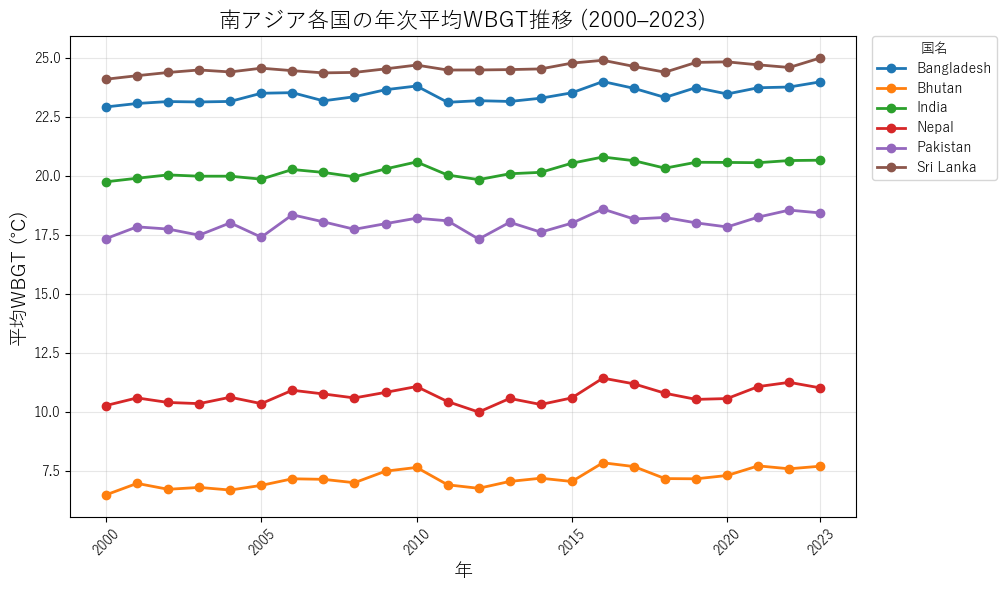

✅ 全国の時系列WBGTグラフを保存しました: ../results/wbgt_trend_all_countries.png


In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['font.family']='Yu Gothic'
# 1) 各年のデータを読み込んで結合
years = list(range(2000, 2024))
df_list = []
for year in years:
    path = f"../data/processed/wbgt/wbgt_by_country_{year}.csv"
    df_year = pd.read_csv(path)      # columns: country, mean_wbgt
    df_year["year"] = year
    df_list.append(df_year)
df_all = pd.concat(df_list, ignore_index=True)

# 2) pivot して「行: year、列: country」の時系列テーブルに変換
df_ts = df_all.pivot(index="year", columns="country", values="mean_wbgt")

# 3) プロット用フォルダを作成
os.makedirs("../results", exist_ok=True)

# 4) 全国を一つの図にまとめて折れ線グラフ描画
plt.figure(figsize=(12, 6))

for country in df_ts.columns:
    # if country != 'Bhutan':
    plt.plot(
        df_ts.index,
        df_ts[country],
        marker="o",
        linewidth=2,
        label=country
    )

# タイトル・ラベルを日本語で
plt.title("南アジア各国の年次平均WBGT推移 (2000–2023)", fontsize=16)
plt.xlabel("年", fontsize=14)
plt.ylabel("平均WBGT (℃)", fontsize=14)

# X軸目盛りを5年おき＋最終年に設定
xticks = years[::5]
if years[-1] not in xticks:
    xticks.append(years[-1])
plt.xticks(xticks, rotation=45)

plt.grid(alpha=0.3)

# 凡例を図の外に配置
plt.legend(
    title="国名",
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    borderaxespad=0
)

plt.tight_layout(rect=[0, 0, 0.85, 1])

# 5) 保存・表示
out_path = "../results/wbgt_trend_all_countries.png"
plt.savefig(out_path, dpi=150)
plt.show()
print(f"✅ 全国の時系列WBGTグラフを保存しました: {out_path}")
